## Pose Estimation -- Humans and Animals
#### Thomas Reynolds

In [1]:
from matplotlib import image
from matplotlib import patches
from matplotlib import pyplot as plt
import json
import pycocotools
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
import albumentations as A

# https://github.com/pytorch/vision/tree/main/references/detection
import sys
sys.path.append('./dependencies')
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

[43, 134, 228, 345]


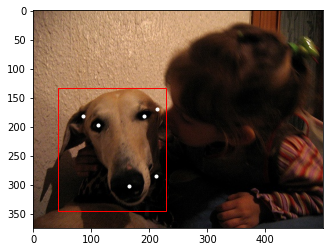

[210, 194, 257, 234]


<Figure size 432x288 with 0 Axes>

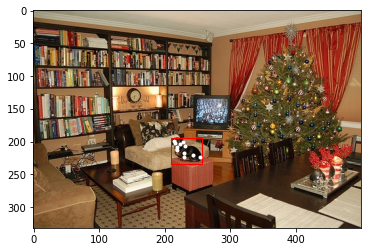

[171, 57, 344, 280]


<Figure size 432x288 with 0 Axes>

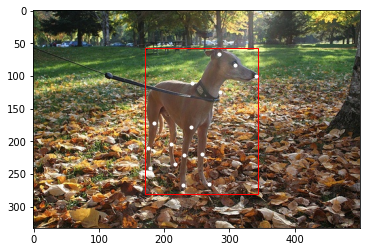

[112, 78, 376, 328]


<Figure size 432x288 with 0 Axes>

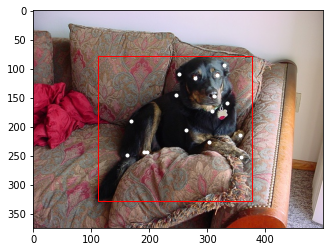

[1, 43, 378, 237]


<Figure size 432x288 with 0 Axes>

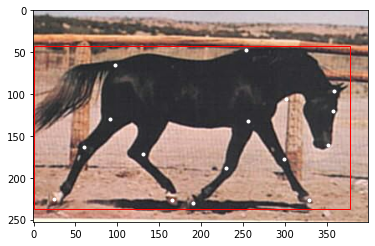

[113, 144, 339, 277]


<Figure size 432x288 with 0 Axes>

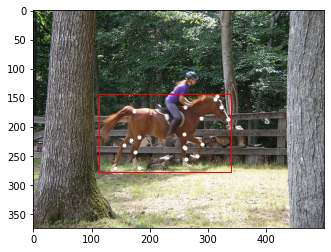

[218, 93, 451, 290]
[196, 122, 279, 258]


<Figure size 432x288 with 0 Axes>

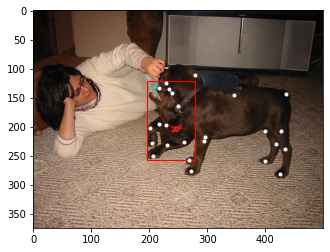

[2, 2, 442, 375]


<Figure size 432x288 with 0 Axes>

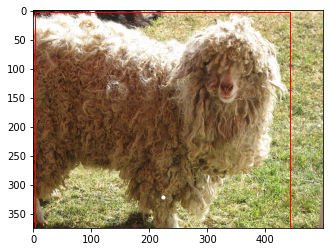

[60, 105, 253, 241]
[2, 128, 151, 270]


<Figure size 432x288 with 0 Axes>

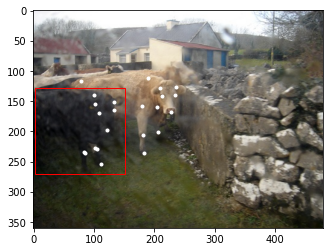

[181, 122, 402, 318]
[1, 100, 197, 221]
[266, 95, 348, 157]
[262, 71, 429, 170]
[433, 79, 493, 218]


<Figure size 432x288 with 0 Axes>

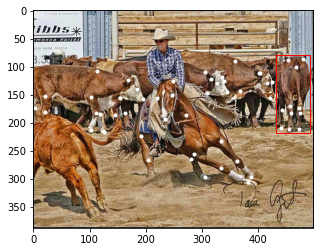

<Figure size 432x288 with 0 Axes>

In [16]:
# Plot the keypoints and bounding box for some images
for i in range(100,110):

    # Read in keypoints data
    with open('data/annotations.json') as f:
        img_info = json.load(f)

    # Get an image
    img_path = 'data/images/' + str(img_info['images'][str(i)])
    test_img = image.imread(img_path)

    # Get the keypoints for the image
    key_data_path = 'data/annotations/' + img_path[12:-4] + '.json'
    with open(key_data_path, 'r') as f:
        key_data = json.loads(f.read())

    # Create figure and axes
    fig, ax = plt.subplots()

    # Annotate over image
    for object in key_data['keypoints']:
        for point in object:
            if point[2] != 0:
                # do stuff
                plt.plot(point[0], point[1], marker='.', color="white")

    plt.imshow(test_img)

    # Create a Rectangle patch
    for bbox in key_data['bboxes']:
        print(bbox)
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()
    plt.clf()

In [17]:
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

In [18]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are glue tubes
            bboxes_labels_original = ['Glue tube' for _ in bboxes_original]            

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,2,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

In [19]:
dataset = ClassDataset('data', transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[3], "\n\n")
print("Transformed targets:\n", batch[1])

IndexError: list index out of range

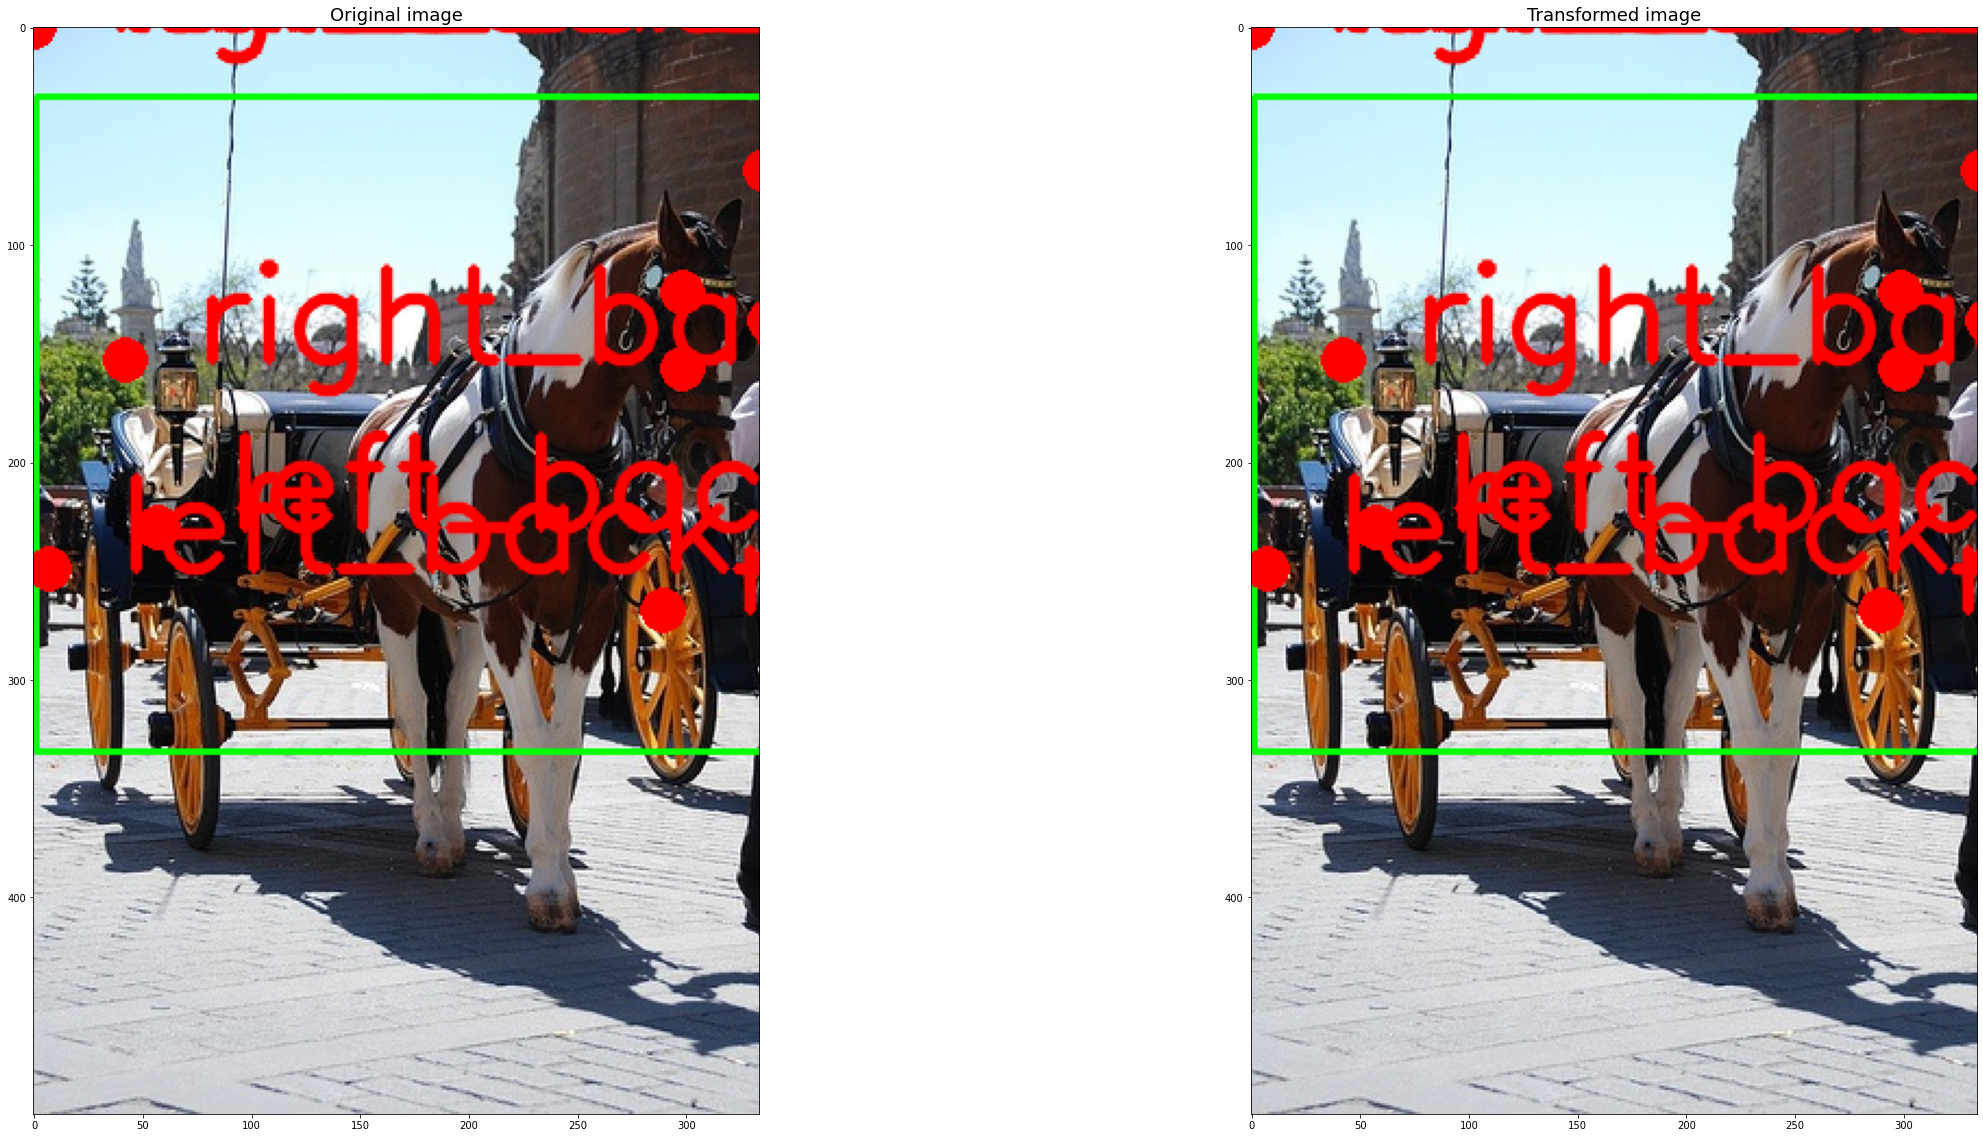

In [21]:
# Show some images

keypoints_classes_ids2names = {0:"left_eye", 1:"right_eye", 2:"nose", 3:"left_ear", 4:"right_ear", 5:"left_front_elbow",
    6:"right_front_elbow", 7:"left_back_elbow", 8:"right_back_elbow", 9:"left_front_knee", 10:"right_front_knee",
    11:"left_back_knee", 12:"right_back_knee", 13:"left_front_paw", 14:"right_front_paw", 15:"left_back_paw",
    16:"right_back_paw", 17:"throat", 18:"withers", 19:"tailbase"}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [4]:
# Get test and train sets
images = img_info['images']
train_size = int(0.8 * len(images))
test_size = len(images) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(images, [train_size, test_size])

print("Train images: ", len(train_dataset))
print("Test images: ", len(test_dataset))

Train images:  3686
Test images:  922


In [5]:
class Hourglass(torch.nn.Module):
  def __init__(self, input_dim, output_dim, kernel_size=3, stride = 1, bn = False, relu = True):
    super(Hourglass, self).__init__()
    self.inp_dim = input_dim
    self.conv = torch.nn.Conv2d(input_dim, output_dim, kernel_size, stride, padding=(kernel_size-1)//2, bias=True)
    self.relu = None
    self.bn = None
    if relu:
      self.relu = torch.nn.ReLU()
    if bn:
      self.bn = torch.nn.BatchNorm2d(output_dim)      
  
  def forward(self, x): 
    assert x.size()[1] == self.inp_dim, "{} {}".format(x.size()[1], self.inp_dim)
    x = self.conv(x)
    if self.bn is not None:
        x = self.bn(x)
    if self.relu is not None:
        x = self.relu(x)
    return x